# Notebook pour le tracé des cartes d'indicateurs SPI CHIRPS (RASTERS)

### Initialisation contexte test appli

In [64]:
import os

WRK_DIR = os.path.normpath('D:/MATHIS/0_Projet_Secheresse/1_Scripts/toolbox/eo4dm-oeil/EO4DM')
os.chdir(WRK_DIR)
WRK_DIR= os.path.join(WRK_DIR,'../DMPIPELINE_WORKST')

TERRITORY = 'New Caledonia (Fr)'
PRODUCT = 'SPI3'
PERIOD = 'MONTH'
DATE = '201708'

TERRITORY_str = TERRITORY.replace(' ', '_').replace('(', '').replace(')', '')
DATA_HISTO = os.path.join(WRK_DIR,'DATA_HISTO_backup',TERRITORY_str)
ANNEX_DIR = os.path.join(WRK_DIR,'ANNEX',TERRITORY_str)
INDIR_RASTERS = os.path.join(DATA_HISTO,'1_INDICATEURS/ALERT/METEO/SPI3_GEE_CHIRPS',PERIOD)
INDIR_ANNEX = os.path.join(ANNEX_DIR,'Areas')


In [65]:
import glob
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar

### Prépare le dossier de sortie

In [66]:
# --- Generate directories/sub-directories ---
OUTDIR_MAPS = os.path.join(WRK_DIR, f'PLOT_MAP_DROUGHT_{TERRITORY_str}')
os.umask(0) # used to reset the directories permission
if not os.path.exists(OUTDIR_MAPS):
    os.makedirs(OUTDIR_MAPS)
    os.chmod(OUTDIR_MAPS, 0o777)

### Lecture et préparation des données

In [67]:
raster_in = glob.glob(os.path.join(INDIR_RASTERS, f'*{PRODUCT}*{DATE}*.tif'))[0]
contours_in = glob.glob(os.path.join(INDIR_ANNEX, '*.shp'))[0]
gdf_contours = gpd.read_file(contours_in)

### Définition des colormaps

In [68]:
colors_drought = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Rouge, blanc, bleu
ticks_drought = [-3, 0, 3]
n_bins = 100  # Nombre de bins pour la colormap
cmap_name = "custom_cmap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors_drought, N=n_bins)

# color_nodata = '#DCDCDC' # lightgray
color_nodata = '#add8e6' # lightblue

### Affichage et export de la carte

In [69]:
gdf_contours['geometry']

0     MULTIPOLYGON Z (((469488.278 414205.868 1.000,...
1     MULTIPOLYGON Z (((228007.984 425914.026 -10000...
2     MULTIPOLYGON Z (((353095.755 339880.000 -10000...
3     MULTIPOLYGON Z (((321514.223 368131.777 -10000...
4     MULTIPOLYGON Z (((248580.913 366116.844 -10000...
5     MULTIPOLYGON Z (((604656.531 281105.390 1.000,...
6     MULTIPOLYGON Z (((378144.773 317552.945 -10000...
7     POLYGON Z ((371109.153 280137.791 9999.000, 37...
8     MULTIPOLYGON Z (((321269.784 300678.563 -10000...
9     MULTIPOLYGON Z (((293983.664 321001.119 -10000...
10    MULTIPOLYGON Z (((416716.427 245328.251 1.000,...
11    MULTIPOLYGON Z (((150476.873 506140.422 1.000,...
12    MULTIPOLYGON Z (((203560.510 423842.597 1.000,...
13    MULTIPOLYGON Z (((450493.347 219925.748 -10000...
14    MULTIPOLYGON Z (((371445.862 277499.216 -10000...
15    MULTIPOLYGON Z (((439992.642 225404.891 -10000...
16    MULTIPOLYGON Z (((191490.890 456172.812 1.000,...
17    MULTIPOLYGON Z (((353095.755 339880.000 -1

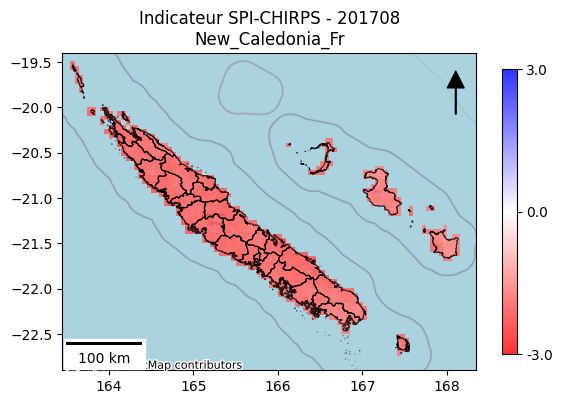

In [70]:
with rasterio.open(raster_in) as src:
    src_crs = src.crs
    gdf_contours = gdf_contours.to_crs(src_crs)
    raster_data = src.read(1)
    bounds = src.bounds

fig, ax = plt.subplots(figsize=(6, 6))

im = ax.imshow(raster_data, cmap=custom_cmap, interpolation='nearest',
               vmin=ticks_drought[0], vmax=ticks_drought[-1],
               extent=(bounds.left, bounds.right, bounds.bottom, bounds.top), alpha=0.8)

cbar  = plt.colorbar(im, ax=ax, ticks=ticks_drought, format="%1.1f", shrink=0.5)
ctx.add_basemap(ax, crs=src_crs, source=ctx.providers.OpenStreetMap.Mapnik, zorder=-1)

# Add Scale bar
distance_meters = 1
if src_crs=='EPSG:4326':
    (bounds.left, bounds.right, bounds.bottom, bounds.top)
    points_x =[bounds.left, bounds.left+1]
    points_y = [bounds.bottom, bounds.bottom]
    points = gpd.GeoSeries.from_xy(points_x, points_y, crs='EPSG:4326')
    points = points.to_crs(3395)
    distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(distance_meters, location='lower left'))

# Add North arrow
arrow_properties = dict(facecolor='black', edgecolor='black', width=0.5, shrink=0.05)
ax.annotate('', xy=(0.95, 0.95), xytext=(0.95, 0.8),
            arrowprops=arrow_properties, ha='center', va='bottom',
            fontsize=12, color='black', xycoords='axes fraction')

gdf_contours.plot(ax=ax, color='none', edgecolor='black', linewidth=0.8, alpha=0.8)

plt.title(f'Indicateur SPI-CHIRPS - {DATE}\n{TERRITORY_str}')
plt.tight_layout()
plt.show()


fig.savefig(os.path.join(OUTDIR_MAPS, f'maps_{PRODUCT}_{TERRITORY_str}_{DATE}.png'), dpi=300)
